# Imports

In [1]:
import numpy as np
from Fit import Fit
from funcs import *
from stats import *
import scienceplots
plt.style.use(['grid'])

# Funcs

In [2]:
def G_R(w, R, R_L, L, C):
    return R / np.sqrt( (R+R_L)**2 + np.power(w*L - 1/(w*C), 2) )

def fase_R(w, R, R_L, L, C):
    return -np.arctan( (w*L - 1/(w*C)) / (R+R_L) )

def G(w, R, R_L, L, C):
    num = np.sqrt( np.power( R*R_L + R_L**2 + np.power(w*L - 1/(w*C), 2) , 2) + R*R*(w*L - 1/(w*C)))
    return num / (np.power(R+R_L, 2) + np.power(w*L - 1 /(w*C), 2))

def fase(w, R, R_L, L, C, a):
    return a*np.arctan( R*(w*L - 1/(w*C)) / (R*R_L + R_L**2 + np.power(w*L - 1/(w*C), 2)))

# RLC

In [18]:
if 1:
    path_folder = 'data.leo/RLC_R/'
    V_res, V_l, fase_res, fase_l, freqs, V_res_err, V_l_err = [], [], [], [], [], [], []

    for i in sorted([int(i) for i in os.listdir(path_folder)]):

        path = path_folder+str(i)+'/'

        CH1,SGN,MTH, V_SGN, V_MTH, zero_CH1, zero_SGN, zero_MTH, m1, m2, m3, dt_CH1, dt_MTH, V_SGN_err, V_MTH_err = analize(path, i, force=True, prec=1e-8,verbose=True)
        
        # x=np.linspace(np.min(CH1[0]), np.max(CH1[0]), 100)

        # plt.figure(figsize=(10,4))
        # plt.plot(x, sine(x, **m1.values.to_dict()), label='CH1 fit', color='red')
        # plt.plot(x, sine(x, **m2.values.to_dict()), label='SGN fit', color='blue')
        # plt.plot(x, sine(x, **m3.values.to_dict()), label='MTH fit', color='green')
        
        # # plt.plot(CH1[0], CH1[1], label='CH1', color='red')
        # # plt.plot(SGN[0], SGN[1], label='SGN', color='blue')
        # # plt.plot(MTH[0], MTH[1], label='MTH', color='green')

        # plt.scatter(zero_CH1, 0, color='red', label='zero CH1')
        # plt.scatter(zero_SGN, 0, color='blue', label='zero SGN')
        # plt.scatter(zero_MTH, 0, color='green', label='zero MTH')
        # plt.legend(ncol=2)
        # plt.show()
        # print(i, dt_CH1, dt_MTH)

        V_res.append(V_SGN)
        V_l.append(V_MTH)
        V_res_err.append(V_SGN_err)
        V_l_err.append(V_MTH_err)
        fase_res.append(dt_CH1*i*2*np.pi)
        fase_l.append(dt_MTH*i*2*np.pi)
        freqs.append(i)

    V_res = np.array(V_res)
    V_l = np.array(V_l)
    V_res_err = np.array(V_res_err)
    V_l_err = np.array(V_l_err)
    fase_res = -np.array(fase_res) + np.pi
    fase_l = -np.array(fase_l) + np.pi
    freqs = np.array(freqs)

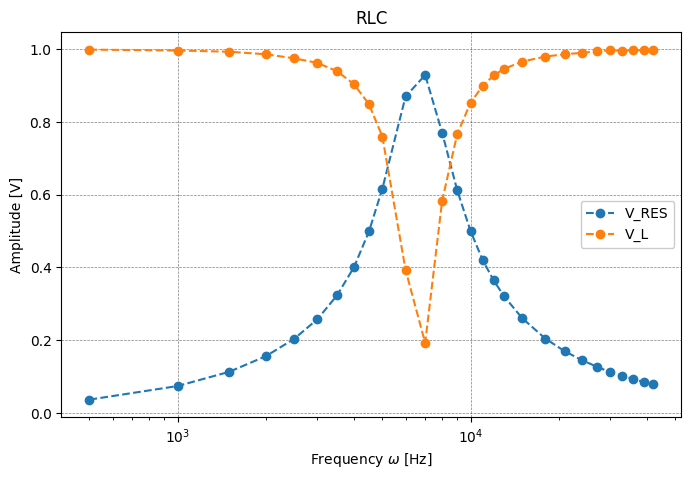

In [4]:
plt.figure(figsize=(8,5))
x = np.linspace(np.min(freqs),np.max(freqs),1000)

# plt.plot(x, H_R(x*2*np.pi, 1e3*12e-9, 0), label='Teorico')
# plt.plot(x, H_C(x*2*np.pi, 1e3*12e-9), label='Teorico')

plt.plot(freqs, V_res, 'o--', label='V_RES')
plt.plot(freqs, V_l, 'o--', label='V_L')
plt.title('RLC')
plt.xlabel('Frequency $\omega$ [Hz]')
plt.ylabel('Amplitude [V]')
plt.legend()
plt.xscale('log')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


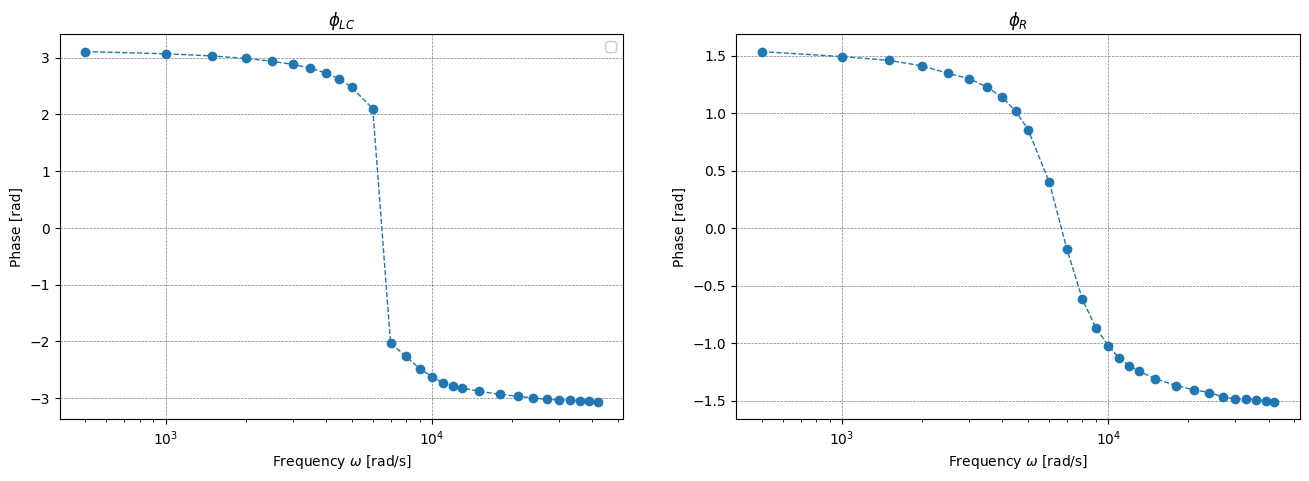

In [60]:
x = np.linspace(np.min(freqs),np.max(freqs),1000)

fase_res_mod = np.array(fase_res)
d = fase_res_mod < 0
u = fase_res_mod > 0
fase_res_mod[d] += 2*np.pi
fase_res_mod -= np.pi

plt.subplots(1,2,figsize=(16,5))
plt.title('Dati')
plt.subplot(1,2,1)
plt.plot(freqs[:], fase_l[:],'o--', lw=1)
plt.title('$\phi_{LC}$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.legend()
plt.xscale('log')

plt.subplot(1,2,2)
plt.plot(freqs[:], fase_res_mod[:], 'o--', lw=1)
# plt.plot(x, fase_C(x*2*np.pi, 1e3, 12e-9, 0), label='Teorico')
# plt.plot(x, fase_R(x*2*np.pi, 1e3, 12e-9), label='Teorico')
plt.title('$\phi_R$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.xscale('log')

# plt.savefig('imgs/RC/fasi_no_log.jpeg', bbox_inches='tight', dpi=200)
plt.show()

# R

In [77]:
c = LeastSquares(freqs*2*np.pi, V_res, V_res_err, G, verbose=False)
f_m = Minuit(c, R=997, R_L=39.9, L=40e-3, C=12e-9)
f_m.fixed['R_L'] = True
f_m.migrad()
f_m.hesse()


C:\Users\Yehan\AppData\Local\Temp\ipykernel_9112\3208174316.py:8: RuntimeWarning: invalid value encountered in sqrt
  num = np.sqrt( np.power( R*R_L + R_L**2 + np.power(w*L - 1/(w*C), 2) , 2) + R*R*(w*L - 1/(w*C)))


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.319e+10 (χ²/ndof = 2127635589.7)│              Nfcn = 302              │
│ EDM = 6.8e+09 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │ 5.4267e3  │ 0.0008e3  │            │            │         │         │       │
│ 1 │ R_L  │   39.9    │    0.4    │            │            │         │         │  yes  │
│ 2 │ L    │-12.0329e-3│ 0.0017e-3 │            │            │         │         │       │
│ 3 │ C    │ 99.708e-9 │ 0.013e-9  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────┐
│     │                  R                R_L                  L                  C │
├─────┼─────────────────────────────────────────────────────────────────────────────┤
│   R │              0.563                0.0      -1.2571381e-6 -9.47389394633e-12 │
│ R_L │                0.0                  0                  0                  0 │
│   L │      -1.2571381e-6                  0           2.82e-12       21.15996e-18 │
│   C │ -9.47389394633e-12                  0       21.15996e-18           1.62e-22 │
└─────┴─────────────────────────────────────────────────────────────────────────────┘

{'R': 902.6434685652249, 'R_L': 53.649499933716115, 'L': 0.044397478303746, 'C': 1.2695419282792327e-08}


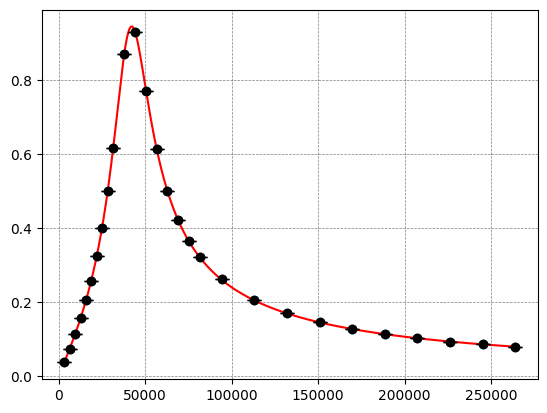

In [74]:
f_m = Fit(freqs*2*np.pi, V_res, G_R, V_res_err, kwargs={'R':1e3, 'R_L':39.9, 'L':0.04, 'C':12e-9})
f_m.fit()
f_m.visualize()
print(f_m.values)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

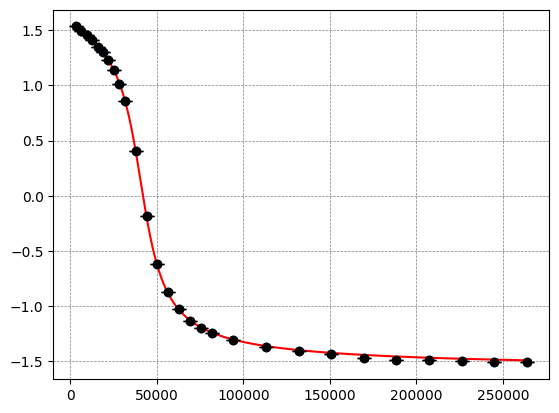

In [48]:
f_f = Fit(freqs*2*np.pi, fase_res_mod, fase_R, V_res_err, kwargs={'R':1e3, 'R_L':20, 'L':0.04, 'C':12e-9})
f_f.fit()
f_f.visualize(npoints=10000)


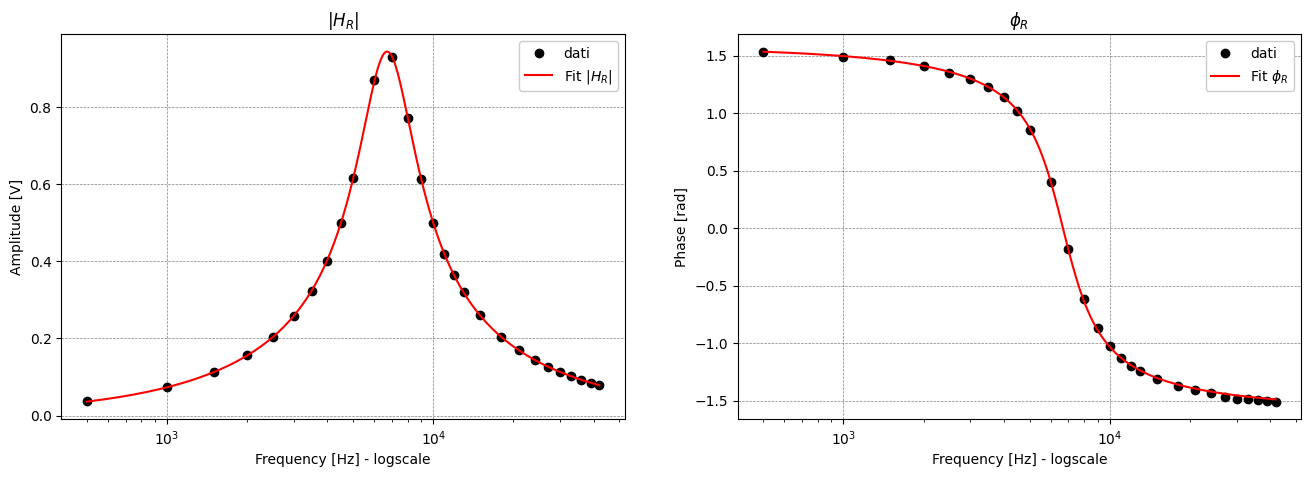

In [59]:
x = np.linspace(np.min(freqs),np.max(freqs),1000)

plt.subplots(1,2,figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(freqs, V_res, 'o', label='dati', c='k')
plt.plot(x, G_R(x*2*np.pi, **f_m.values), label='Fit $|H_R|$', c='r')
plt.title('$|H_R|$')
plt.legend()
plt.xlabel('Frequency [Hz] - logscale')
plt.ylabel('Amplitude [V]')
plt.xscale('log')

plt.subplot(1,2,2)
plt.plot(freqs, fase_res_mod, 'o', label='dati', c='k')
plt.plot(x, fase_R(x*2*np.pi, **f_f.values), label='Fit $\phi_R$', c='r')
plt.title('$\phi_R$')
plt.legend()
plt.xlabel('Frequency [Hz] - logscale')
plt.ylabel('Phase [rad]')
plt.xscale('log')

# LC

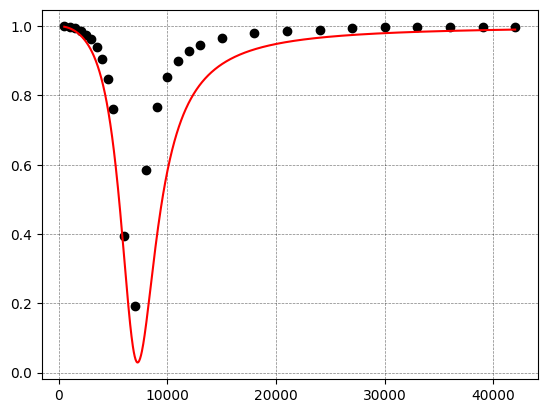

In [67]:
x = np.linspace(np.min(freqs),np.max(freqs),1000)
y = G(x*2*np.pi, **f_m.values)
plt.plot(x, y, label='Fit $|H_R|$', c='r')
plt.scatter(freqs, V_l, label='dati', c='k')

In [70]:
f_m = Fit(freqs*2*np.pi, V_l, G, 0.01, kwargs={'R':1e3, 'R_L':30, 'L':0.04, 'C':12e-9})
f_m.fit()
f_m.visualize()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.